<a href="https://colab.research.google.com/github/Jackelyneg/covid-19-image-classification/blob/main/xraymodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.preprocessing.image
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import os;
import datetime  
import cv2 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm  
%matplotlib inline
from glob import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
batch_size = 32
img_height = 256
img_width = 256

In [16]:
ls "/content/drive/MyDrive/project4data"

covid/  normal/


In [5]:
filepath="/content/drive/MyDrive/project4data"

In [7]:
# the training dataset
training_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    filepath,
    labels="inferred",
    label_mode="categorical",
    #class_names=None,
    class_names=['normal', 'covid'],
    color_mode="grayscale",
    #batch_size=32,
    #image_size=(256, 256),
    shuffle=True,
    seed=123,#
    validation_split=0.2,
    subset="training",#to divide the dataset into training
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 94 files belonging to 2 classes.
Using 76 files for training.


In [9]:
# the testing/validation Dataset

val_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    filepath,
    labels="inferred",
    #label_mode="binary",
    #label_mode=None,
    label_mode="categorical",
    class_names=['normal', 'covid'],
    color_mode="grayscale",
    #batch_size=32,
    #image_size=(256, 256),
    shuffle=True,
    seed=123,#
    validation_split=0.2,
    subset="validation",#to divide the dataset into training
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
        image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 94 files belonging to 2 classes.
Using 18 files for validation.


In [10]:
val_dataset

<BatchDataset shapes: ((None, 256, 256, 1), (None, 2)), types: (tf.float32, tf.float32)>

In [11]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
AUTOTUNE = tf.data.AUTOTUNE

training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
num_classes = 2

input_shape=(1,256,256,1)
model = Sequential([
  #layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation="softmax")
])
model

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [26]:
model.build(input_shape)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (1, 256, 256, 16)         160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (1, 128, 128, 16)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (1, 128, 128, 32)         4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (1, 64, 64, 32)           0         
_________________________________________________________________
conv2d_11 (Conv2D)           (1, 64, 64, 64)           18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (1, 32, 32, 64)           0         
_________________________________________________________________
flatten_3 (Flatten)          (1, 65536)               

In [27]:
epochs=10
history = model.fit(
  training_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/10
3/3 [==============================] - 19s 3s/step - loss: 678.2105 - accuracy: 0.5132 - val_loss: 782.1600 - val_accuracy: 0.6667
Epoch 2/10
3/3 [==============================] - 5s 2s/step - loss: 333.1669 - accuracy: 0.7500 - val_loss: 89.3274 - val_accuracy: 0.6667
Epoch 3/10
3/3 [==============================] - 6s 2s/step - loss: 35.7943 - accuracy: 0.5526 - val_loss: 10.6038 - val_accuracy: 0.3333
Epoch 4/10
3/3 [==============================] - 6s 2s/step - loss: 7.4555 - accuracy: 0.5395 - val_loss: 6.8710 - val_accuracy: 0.6667
Epoch 5/10
3/3 [==============================] - 5s 2s/step - loss: 2.2372 - accuracy: 0.7895 - val_loss: 4.4063 - val_accuracy: 0.3333
Epoch 6/10
3/3 [==============================] - 5s 2s/step - loss: 1.5371 - accuracy: 0.6184 - val_loss: 0.4770 - val_accuracy: 0.8333
Epoch 7/10
3/3 [==============================] - 6s 2s/step - loss: 0.4402 - accuracy: 0.8553 - val_loss: 0.6132 - val_accuracy: 0.8333
Epoch 8/10
3/3 [===============

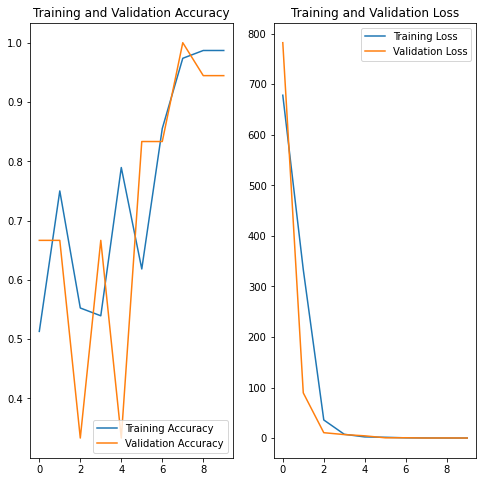

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
# Save the model
model.save("mymodel.h5")

In [30]:
# Load the model
from tensorflow.keras.models import load_model
model = load_model("mymodel.h5")

In [31]:
# Evaluate the model using the testing data 
model_loss, model_accuracy = model.evaluate(val_dataset,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

1/1 - 1s - loss: 0.0656 - accuracy: 0.9444
Loss: 0.06562704592943192, Accuracy: 0.9444444179534912


In [36]:
from tensorflow.keras.preprocessing import image
filepathClear="/content/drive/MyDrive/Colab Notebooks/normal.jpeg"
filepathCovid="/content/drive/MyDrive/covidimage.jpeg"

[[0. 1.]]
Predicted class: [1]


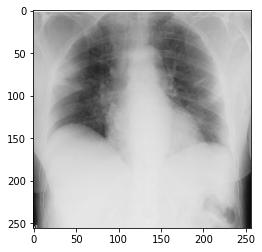

In [37]:
image_size = (256, 256,1)
im = image.load_img(filepathCovid, target_size=image_size, color_mode="grayscale")
from tensorflow.keras.preprocessing.image import img_to_array
image = img_to_array(im)
image.shape
# Scale the image pixels by 255 (or use a scaler from sklearn here)
#image /= 255

# Flatten into a 1x28*28 array 
img = image.flatten().reshape( -1,256, 256,1)
img.shape
plt.imshow(img.reshape(256, 256))

# Invert the pixel values to match the original data
img = 1 - img
plt.imshow(img.reshape(256, 256), cmap=plt.cm.Greys)

predictions = model.predict(img)
print(predictions)
print(f"Predicted class: {np.argmax(predictions,axis=1)}")

[[0.9950477  0.00495235]]
Predicted class: [0]


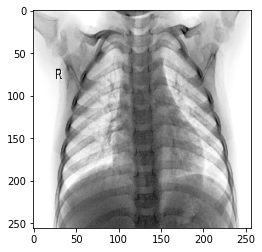

In [39]:
image_size = (256, 256,1)
from tensorflow.keras.preprocessing import image

im2 = image.load_img(filepathClear, target_size=image_size, color_mode="grayscale")
#from tensorflow.keras.preprocessing.image import img_to_array
image2 = img_to_array(im2)
image2.shape
# Scale the image pixels by 255 (or use a scaler from sklearn here)
#image2 /= 255

# Flatten into a 1x28*28 array 
img2 = image2.flatten().reshape( -1,256, 256,1)
img2.shape
plt.imshow(img2.reshape(256, 256))

# Invert the pixel values to match the original data
img = 1 - img2
plt.imshow(img2.reshape(256, 256), cmap=plt.cm.Greys)

predictions1 = model.predict(img2)
print(predictions1)
print(f"Predicted class: {np.argmax(predictions1,axis=1)}")